<a href="https://colab.research.google.com/github/IPL-UV/rbig_jax/blob/master/notebooks/3.0_simple_rbig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo - RBIG

This is a tldr demonstration for how we can use RBIG to Gaussianize multivariate data, estimate probabilities and draw samples from our distribution.

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
from rbig_jax.models.itergauss import IterativeGaussianization

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

We are going to generate a 2D dataset and plot the joint distribution.

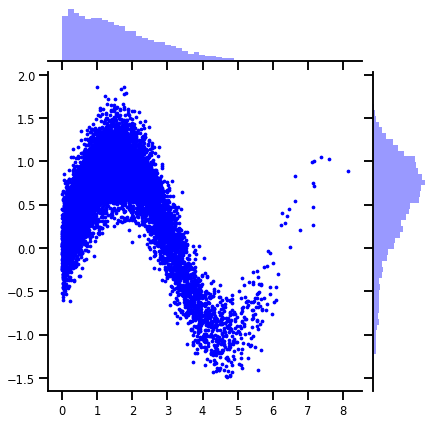

In [3]:
# %%wandb
# get data
n_samples = 10_000
n_features = 2
data = get_classic(n_samples)

# plot data
sns.jointplot(data[:, 0], data[:, 1], s=5, color='blue')

You can clearly see that this is not Gaussian; neither jointly nor marginally. Our objective is to use the RBIG algorithm to make this density jointly Gaussian or Gaussian.

### RBIG Object

RBIG works very similarly as an scikit-learn function. Meaning it follows the standard `transform`, `inverse_transform`, `predict_proba` and `score`.

### Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In this first example, we're going to do a single RBIG transformation to see what happens.

In [4]:
X = np.array(data, dtype=np.float32)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Initialize Standards

In [6]:
# from rbig_jax.models

In [7]:
from rbig_jax.transforms.histogram import InitUniHistUniformize
from rbig_jax.transforms.rotation import InitPCARotation
from rbig_jax.transforms.kde import InitKDEUniformize




support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
uni_uniformize = InitUniHistUniformize(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

# support_extension = 60
# bw = 0.1
# precision = 100

# # initialize histogram transformation
# uni_uniformize = InitKDEUniformize(
#     n_samples=X.shape[0],
#     support_extension=support_extension,
#     precision=precision,
#     bw=bw
# )

# initialize rotation transformation
rot_transform = InitPCARotation()

## Fit Transform

In [10]:
max_layers = 1_000
zero_tolerance = 30
itergauss_model = IterativeGaussianization(
    uni_uniformize=uni_uniformize, 
    rot_transform=rot_transform, 
    max_layers=max_layers,
    n_features=n_features,
    zero_tolerance=zero_tolerance,
)

### Fit Transform

In [11]:
%%time

# itergauss_model.fit(X)

X_g = itergauss_model.fit_transform(X.block_until_ready())

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 6.23 s, sys: 3.61 s, total: 9.84 s
Wall time: 5.35 s


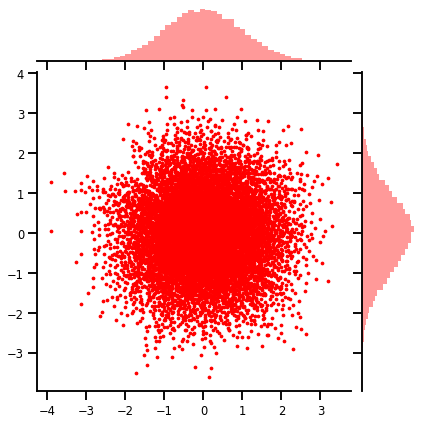

In [12]:
sns.jointplot(X_g[:, 0], X_g[:, 1], s=5, color='red')

### Inverse Transform

In [23]:
%%time

X_approx = itergauss_model.inverse_transform(X_g.block_until_ready())

CPU times: user 770 ms, sys: 2.54 ms, total: 773 ms
Wall time: 769 ms


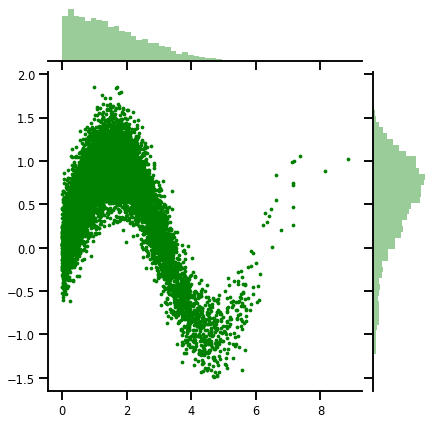

In [25]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='green')

### Log Probability

In [26]:
%%time

X_log_prob = itergauss_model.score_samples(X.block_until_ready())

CPU times: user 1.58 s, sys: 121 ms, total: 1.7 s
Wall time: 1.11 s


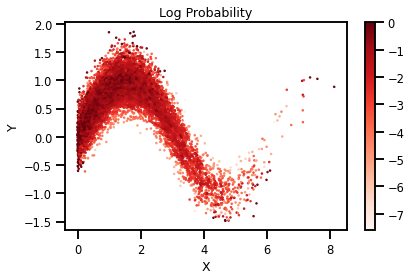

In [27]:
cmap = "Reds"
probs = X_log_prob
# probs = np.clip(probs, 0.0, 1.0)
probs = np.clip(probs, None, 0.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(X[:, 0], X[:, 1], s=1, c=probs, cmap=cmap, vmax=0.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

### Probability

In [28]:
ngrid = 1_000
buffer = 0.1
xline = np.linspace(data[:,0].min()-buffer, data[:,0].max()+buffer, ngrid)
yline = np.linspace(data[:,1].min()-buffer, data[:,1].max()+buffer, ngrid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [29]:
%%time

X_log_prob = itergauss_model.score_samples(xyinput)

CPU times: user 1.74 s, sys: 202 ms, total: 1.94 s
Wall time: 1.22 s


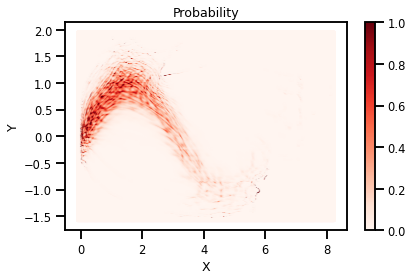

In [30]:
cmap = "Reds"
probs = np.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs,  cmap=cmap, vmin=0.0, vmax=1.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

#### Negative Log-Likelihood

In [31]:
nll = itergauss_model.score(X.block_until_ready())

print("Negative Log-Likelihood:", nll)

Negative Log-Likelihood: 1.2509962


### Sampling

In [34]:
%%time

n_samples = 10_000

X_samples = itergauss_model.sample(n_samples)

CPU times: user 986 ms, sys: 0 ns, total: 986 ms
Wall time: 976 ms


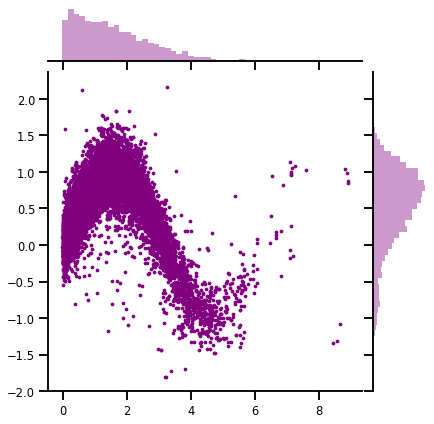

In [35]:
sns.jointplot(X_samples[:, 0], X_samples[:, 1], s=5, color='purple')

## Information Theory

### Total Correlation

In [36]:
TC = itergauss_model.total_correlation()


print(TC)

1.0546341


### Entropy

In [37]:
from rbig_jax.information.entropy import histogram_entropy

In [38]:
# marginal entropy
X_mH = jax.vmap(histogram_entropy, in_axes=(1,None,None))(X, 2, 100).sum()

# total entropy
H = X_mH - TC

print(H)

2.0269191
